In [21]:
import matplotlib.pyplot as plt
import scanpy as sc
import scvi
import fsspec
import scvi
import scvelo as scv
import h5py
import anndata
import pandas as pd
import network
import numpy as np
import matplotlib as plt
import networkx
import desc 
import matplotlib
import umap
import seaborn as sns
import scib
import torch
#import scarches as sca
#from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown
from scvi.model.utils import mde
import pymde
import muon
import anndata
import matplotlib as mpl
%matplotlib inline 
%load_ext rpy2.ipython
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
sc.settings.verbosity = 3 
sc.set_figure_params(figsize=(4, 4))

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/_settings.py:450: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


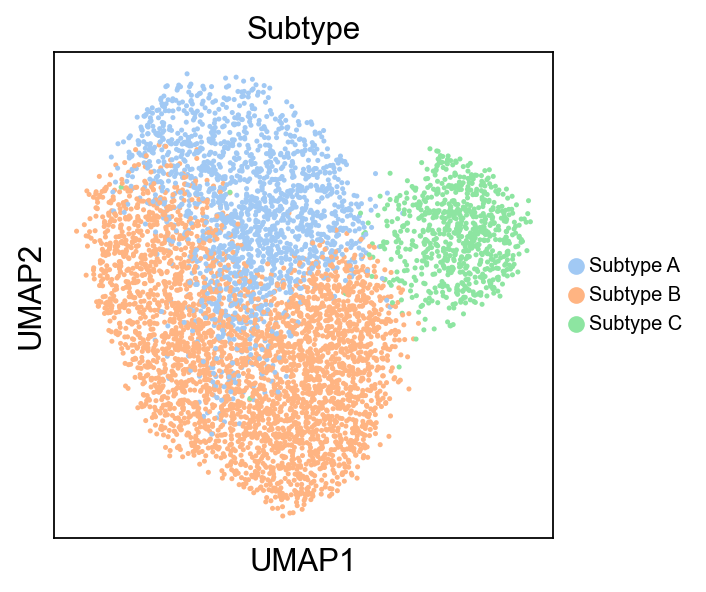

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


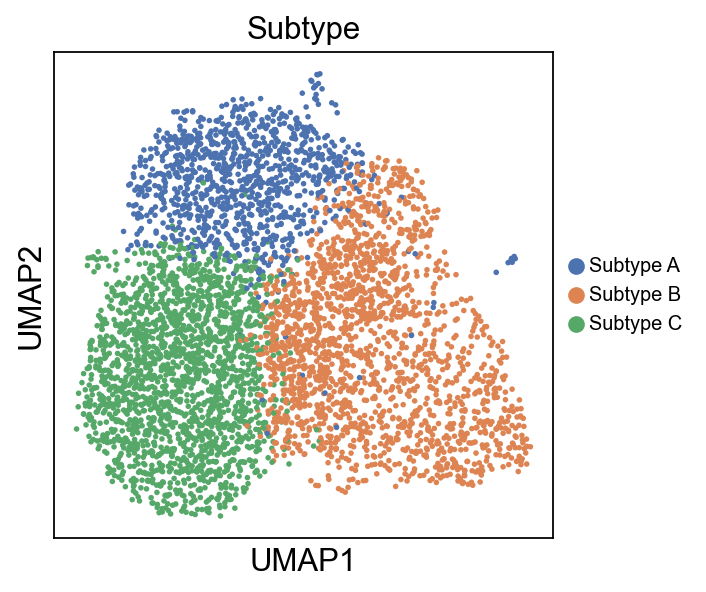

In [22]:
# reading in the adata file from the subtype data
adata_152 = scv.read("/Users/brendamelano/Desktop/OS152_adata_labeled.h5ad")

sc.pl.umap(adata_152, color=['Subtype'], legend_fontsize=9)

# setting keys
cell_type_key = 'Subtype'

# reading in the adata file from the subtype data
adata_742 = scv.read("/Users/brendamelano/Desktop/os_data/OS742/scvi_742_adata_subtypes.h5ad")

sc.pl.umap(adata_742, color=['Subtype'], legend_fontsize=9)

In [23]:
adata_742.obs.rename(columns={'pct_counts_mt': 'percent.mt'}, inplace=True)

# Creating Gene lists

In [24]:
# making a gene list for OS384
OS742_var_names = list(adata_742.var.index.values)


# remove duplicated from list 
OS742_genes = [] 
for i in OS742_var_names: 
    if i not in OS742_genes: 
        OS742_genes.append(i) 
        
        
# making a list of 152 genes
OS152_genes = list(adata_152.var.index.values)


# Python program to illustrate the intersection
# of two lists using set() method
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))
 
    
# identiyfing the common genes within these samples
common_genes = intersection(OS742_genes, OS152_genes)


# filtering 152 for the common genes
muon.pp.filter_var(adata_152, common_genes)


muon.pp.filter_var(adata_742, common_genes)

# setting up the anndata object to include continuous covariate variables
scvi.model.SCVI.setup_anndata(
    adata_152,
    layer="counts",
    continuous_covariate_keys=["percent.mt", "ccdifference"]
)

# setting up the anndata object to include continuous covariate variables
scvi.model.SCVI.setup_anndata(
    adata_742,
    layer="counts",
    continuous_covariate_keys=["percent.mt", "ccdifference"]
)

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:91: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


# OS152 to OS742

In [6]:
# setting up the scvi model
# is there a way to just import this model?
vae_152 = scvi.model.SCVI(adata_152, n_layers=2, n_latent=30, gene_likelihood="nb")

vae_152.train()

# saving the normalized expression values
adata_152.layers["scvi_normalized"] = vae_152.get_normalized_expression(
    library_size=10e4
)


# getting the latent representation
latent = vae_152.get_latent_representation()


# adding the latent variables to the adata object
adata_152.obsm["X_scVI"] = latent


# using the scVI latent space for umap generation
sc.pp.neighbors(adata_152, use_rep="X_scVI")
sc.tl.umap(adata_152, min_dist=0.3)

Tcl_WaitForEvent: Notifier not initialized
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Tcl_WaitForEvent: Notifier not initialized


Epoch 400/400: 100%|███████| 400/400 [02:34<00:00,  2.60it/s, loss=158, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|███████| 400/400 [02:34<00:00,  2.59it/s, loss=158, v_num=1]


running Leiden clustering
    finished: found 4 clusters and added
    'leiden_scVI', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


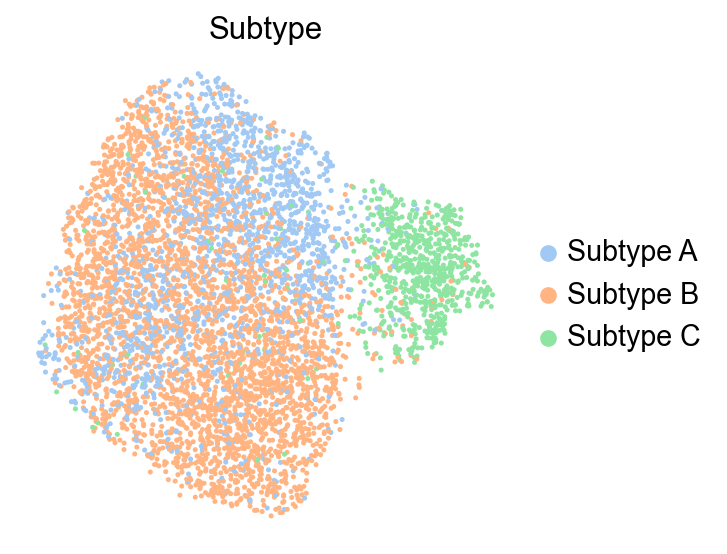

In [8]:
# clustering using the leiden algorithm
# neighbors were already computed using scVI
sc.tl.leiden(adata_152, key_added="leiden_scVI", resolution=0.55)

# plotting the clusters
sc.pl.umap(
    adata_152,
    color=["Subtype"],
    frameon=False,
)

# unlabeled category does not exist in adata.obs[labels_key]
# so all cells are treated as labeled
vae_ref_scan = scvi.model.SCANVI.from_scvi_model(
    vae_152,
    unlabeled_category= "Unknown",
    labels_key= "Subtype",
)

# training the reference model
vae_ref_scan.train(max_epochs=20, n_samples_per_label=100)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


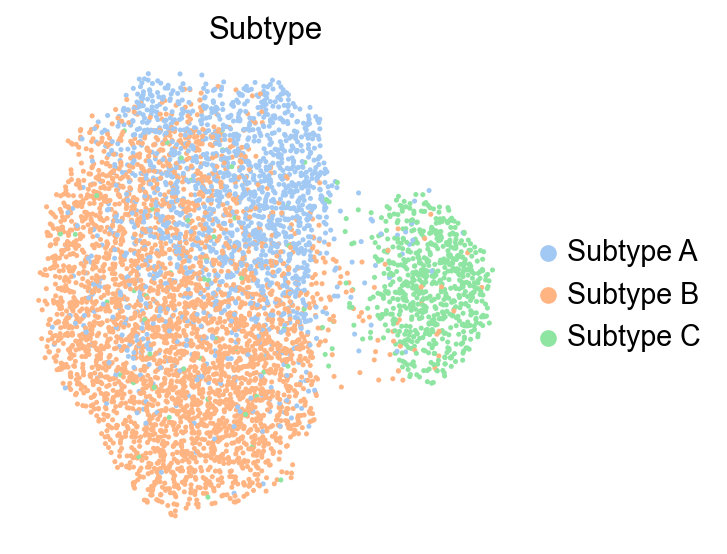

INFO     File OS152_model_scanvi_full_742/model.pt already downloaded                                              
INFO     Found 100.0% reference vars in query data.                                                                
INFO     File OS152_model_scanvi_full_742/model.pt already downloaded                                              
INFO     Training for 100 epochs.                                                                                  


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:91: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 100/100: 100%|███████| 100/100 [00:57<00:00,  1.68it/s, loss=199, v_num=1]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|███████| 100/100 [00:57<00:00,  1.75it/s, loss=199, v_num=1]


In [12]:
# saving the latent representation from the reference model
adata_152.obsm["X_scANVI"] = vae_ref_scan.get_latent_representation()
sc.pp.neighbors(adata_152, use_rep="X_scANVI")
sc.tl.leiden(adata_152)
sc.tl.umap(adata_152)


# plotting the umap
sc.pl.umap(
    adata_152,
    color=["Subtype"],
    frameon=False,
    ncols=1,
)


dir_path_scan = "OS152_model_scanvi_full_742/"
vae_ref_scan.save(dir_path_scan, overwrite=True)



# preparing the query data
scvi.model.SCANVI.prepare_query_anndata(adata_742, dir_path_scan)


# loading the query data
vae_q = scvi.model.SCANVI.load_query_data(
    adata_742,
    dir_path_scan,
)


# training the query model
vae_q.train(
    max_epochs=100,
    plan_kwargs=dict(weight_decay=0.0),
    check_val_every_n_epoch=10,
)


# getting the latent representation from the query model and saving it on the adata 384 dataset
adata_742.obsm["X_scANVI"] = vae_q.get_latent_representation()

In [13]:
# saving the normalized expression values
adata_742.layers["scvi_normalized"] = vae_q.get_normalized_expression(
    library_size=10e4
)


# getting the latent representation
latent = vae_q.get_latent_representation()


# adding the latent variables to the adata object
adata_742.obsm["X_scVI"] = latent


# using the scVI latent space for umap generation
sc.pp.neighbors(adata_742, use_rep="X_scVI")
sc.tl.umap(adata_742, min_dist=0.3)


# clustering using the leiden algorithm
# neighbors were already computed using scVI
sc.tl.leiden(adata_742, key_added="leiden_scVI", resolution=0.5)

# plotting the clusters
sc.pl.umap(
    adata_742,
    color=["Subtype"],
    frameon=False,
)


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


In [16]:
adata_742.obs["predictions"] = vae_q.predict()

df = adata_742.obs.groupby(["Subtype", "predictions"]).size().unstack(fill_value=0)

df.head()

norm_df = df / df.sum(axis=0)

norm_df.head()

norm = mpl.colors.Normalize(vmin=0, vmax=1)

plt.figure(figsize=(8, 8))

_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
_ = plt.colorbar(mpl.cm.ScalarMappable(norm = norm),
             orientation='vertical', label='Percentage')
plt.xlabel("Predicted")
plt.ylabel("Observed")


predictions,Subtype A,Subtype B,Subtype C
Subtype,,,
Subtype A,27,6,999
Subtype B,10,230,1584
Subtype C,1,1,1918


# OS742 to OS152

In [25]:
# setting up the scvi model
# is there a way to just import this model?
vae_742 = scvi.model.SCVI(adata_742, n_layers=2, n_latent=30, gene_likelihood="nb")

vae_742.train()

# saving the normalized expression values
adata_742.layers["scvi_normalized"] = vae_742.get_normalized_expression(
    library_size=10e4
)


# getting the latent representation
latent = vae_742.get_latent_representation()


# adding the latent variables to the adata object
adata_742.obsm["X_scVI"] = latent


# using the scVI latent space for umap generation
sc.pp.neighbors(adata_742, use_rep="X_scVI")
sc.tl.umap(adata_742, min_dist=0.3)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|███████| 400/400 [02:12<00:00,  3.10it/s, loss=129, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|███████| 400/400 [02:12<00:00,  3.02it/s, loss=129, v_num=1]
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


running Leiden clustering
    finished: found 8 clusters and added
    'leiden_scVI', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


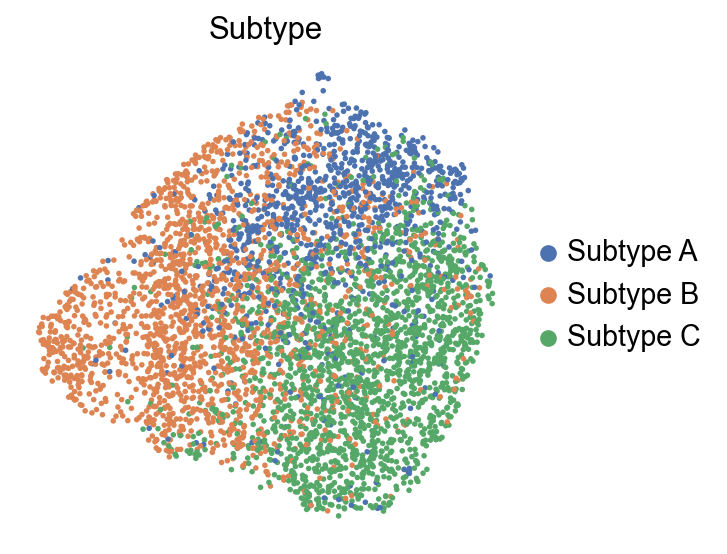

INFO     Training for 20 epochs.                                                                                   


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:91: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 20/20: 100%|███████████| 20/20 [00:14<00:00,  1.41it/s, loss=138, v_num=1]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|███████████| 20/20 [00:14<00:00,  1.38it/s, loss=138, v_num=1]


In [26]:
# clustering using the leiden algorithm
# neighbors were already computed using scVI
sc.tl.leiden(adata_742, key_added="leiden_scVI", resolution=0.55)

# plotting the clusters
sc.pl.umap(
    adata_742,
    color=["Subtype"],
    frameon=False,
)

# unlabeled category does not exist in adata.obs[labels_key]
# so all cells are treated as labeled
vae_ref_scan = scvi.model.SCANVI.from_scvi_model(
    vae_742,
    unlabeled_category= "Unknown",
    labels_key= "Subtype",
)

# training the reference model
vae_ref_scan.train(max_epochs=20, n_samples_per_label=100)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 16 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


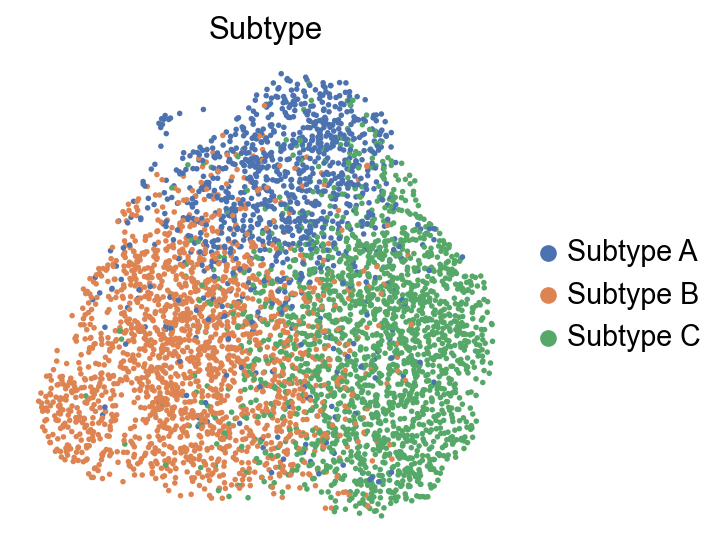

INFO     File OS742_model_scanvi_full_152/model.pt already downloaded                                              
INFO     Found 100.0% reference vars in query data.                                                                
INFO     File OS742_model_scanvi_full_152/model.pt already downloaded                                              
INFO     Training for 100 epochs.                                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 100/100: 100%|███████| 100/100 [01:09<00:00,  1.42it/s, loss=235, v_num=1]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|███████| 100/100 [01:09<00:00,  1.44it/s, loss=235, v_num=1]


In [27]:
# saving the latent representation from the reference model
adata_742.obsm["X_scANVI"] = vae_ref_scan.get_latent_representation()
sc.pp.neighbors(adata_742, use_rep="X_scANVI")
sc.tl.leiden(adata_742)
sc.tl.umap(adata_742)


# plotting the umap
sc.pl.umap(
    adata_742,
    color=["Subtype"],
    frameon=False,
    ncols=1,
)


dir_path_scan = "OS742_model_scanvi_full_152/"
vae_ref_scan.save(dir_path_scan, overwrite=True)



# preparing the query data
scvi.model.SCANVI.prepare_query_anndata(adata_152, dir_path_scan)


# loading the query data
vae_q = scvi.model.SCANVI.load_query_data(
    adata_152,
    dir_path_scan,
)


# training the query model
vae_q.train(
    max_epochs=100,
    plan_kwargs=dict(weight_decay=0.0),
    check_val_every_n_epoch=10,
)


# getting the latent representation from the query model and saving it on the adata 384 dataset
adata_152.obsm["X_scANVI"] = vae_q.get_latent_representation()

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden_scVI', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


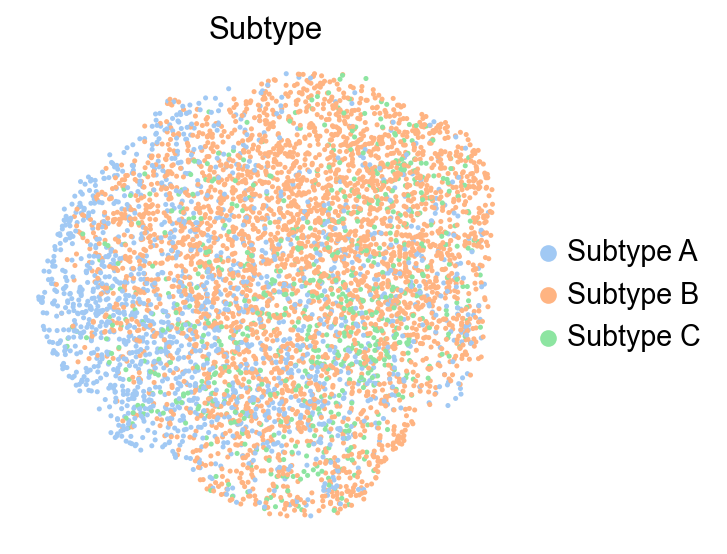

In [28]:
# saving the normalized expression values
adata_152.layers["scvi_normalized"] = vae_q.get_normalized_expression(
    library_size=10e4
)


# getting the latent representation
latent = vae_q.get_latent_representation()


# adding the latent variables to the adata object
adata_152.obsm["X_scVI"] = latent


# using the scVI latent space for umap generation
sc.pp.neighbors(adata_152, use_rep="X_scVI")
sc.tl.umap(adata_152, min_dist=0.3)


# clustering using the leiden algorithm
# neighbors were already computed using scVI
sc.tl.leiden(adata_152, key_added="leiden_scVI", resolution=0.5)

# plotting the clusters
sc.pl.umap(
    adata_152,
    color=["Subtype"],
    frameon=False,
)


/var/folders/lt/nhcx288j6jjfg45n3bhh1mjh0000gn/T/ipykernel_33569/4226050577.py:18: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  _ = plt.colorbar(mpl.cm.ScalarMappable(norm = norm),


Text(0, 0.5, 'Observed')

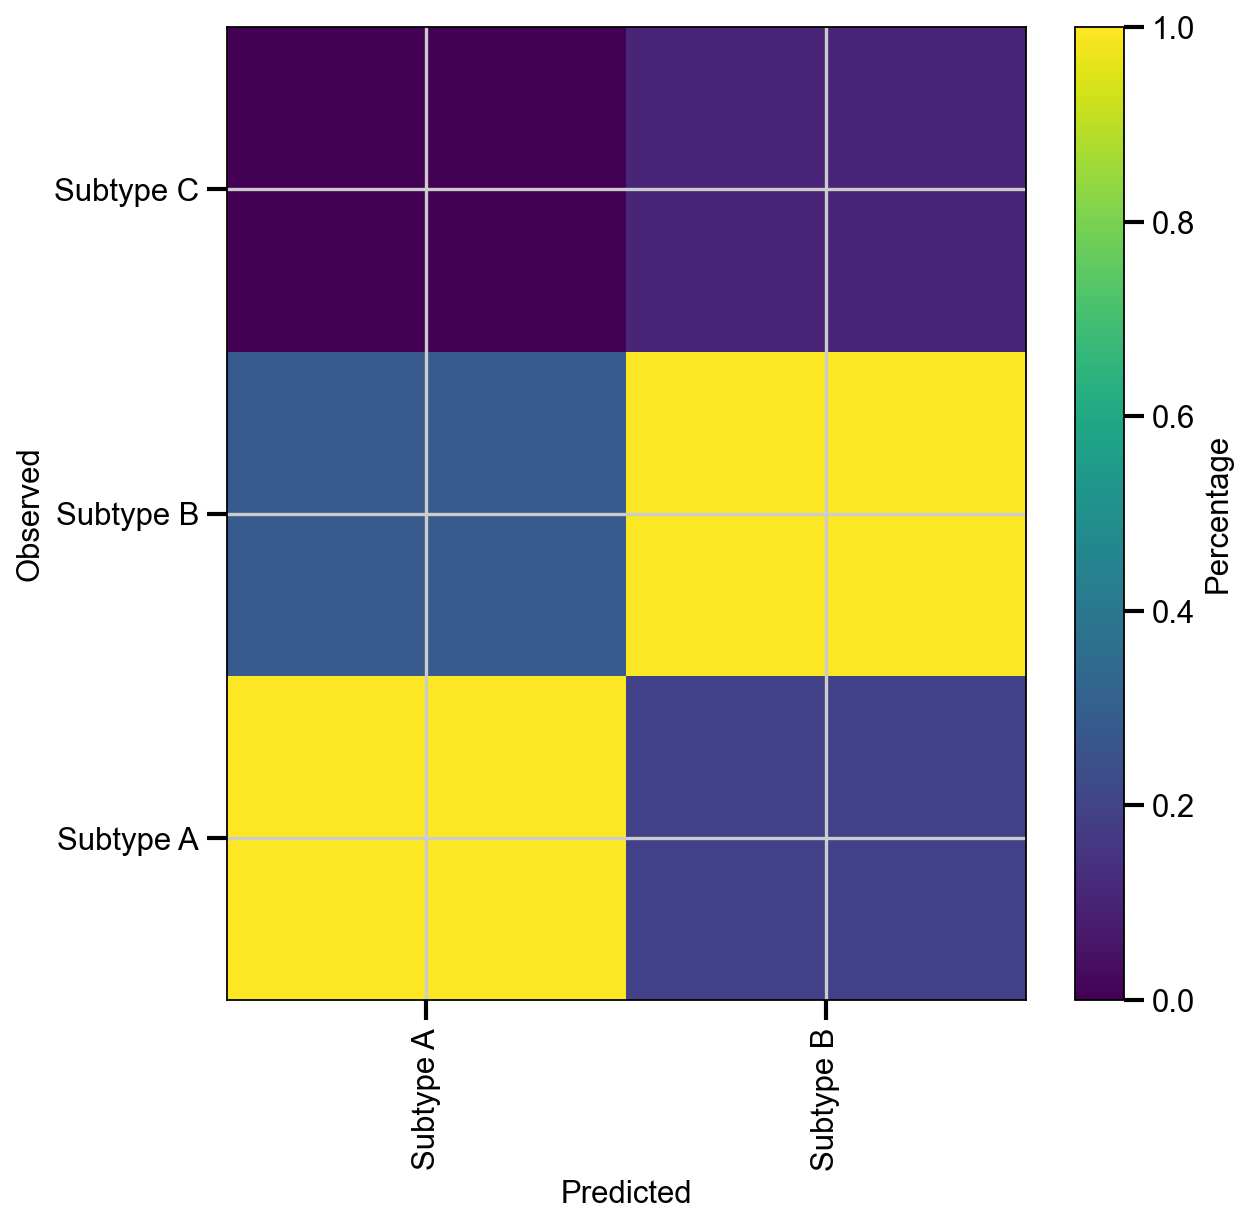

In [29]:
adata_152.obs["predictions"] = vae_q.predict()

df = adata_152.obs.groupby(["Subtype", "predictions"]).size().unstack(fill_value=0)

df.head()

norm_df = df / df.sum(axis=0)

norm_df.head()

norm = mpl.colors.Normalize(vmin=0, vmax=1)

plt.figure(figsize=(8, 8))

_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
_ = plt.colorbar(mpl.cm.ScalarMappable(norm = norm),
             orientation='vertical', label='Percentage')
plt.xlabel("Predicted")
plt.ylabel("Observed")
